In [1]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, \
    Flatten, \
    Reshape, Conv2DTranspose
from tensorflow.keras import backend as K
import cv2
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import BaseLogger
import json
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import math

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:

def showImage(image, isGray=False):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')





data_gen_args = dict(
    rotation_range=20.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


def get_augmented(
        X_train,
        Y_train,
        X_val=None,
        Y_val=None,
        batch_size=32,
        seed=0,
        data_gen_args=dict(
            rotation_range=10.,
            width_shift_range=0.02,
            height_shift_range=0.02,
            zca_whitening=False,
            zca_epsilon=1e-6,
            shear_range=5,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='nearest'
        )):
    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)

    train_generator = zip(X_train_augmented, Y_train_augmented)
    return train_generator


def my_generator(
        X_train,
        Y_train,
        train_gen,
        X_val=None,
        Y_val=None,
        batch_size=2,
        seed=0,
        data_gen_args=dict(
            rotation_range=10.,
            width_shift_range=0.02,
            height_shift_range=0.02,
            zca_whitening=False,
            zca_epsilon=1e-6,
            shear_range=5,
            zoom_range=0.3,
            horizontal_flip=False,
            vertical_flip=False,
            fill_mode='nearest'
        )):
    while 1:
        sample_batch = next(train_gen)
        xx, yy = sample_batch
        yield (xx, yy)


def wczytanieObrazkow(labelsDIR, FACTOR=1):
    imagesDIR = sorted(glob.glob(labelsDIR + '*.bmp'))

    images = np.zeros((len(imagesDIR), 128, 128, 1), dtype=np.float32)
    for im in range(len(imagesDIR)):
        image = cv2.imread(imagesDIR[im])[:, :, 0:1] / FACTOR
        images[im] = image

    return images

def Dice(yt, yp, TH=0.5):
    return 2 * np.sum((yt > TH) * (yp > TH)) / (np.sum(yt > TH) + np.sum(yp > TH))

def encoder(inp_s=(128, 128, 1)):
    input_img = Input(shape=inp_s)

    # 64x64
    # 512x512
    x = Conv2D(16, 3, strides=2, padding='same')(input_img)
    x = Activation('relu')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)

    # 32x32
    # 256x256
    x = Conv2D(32, 3, strides=2, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)

    # 16x16
    # 128x128
    x = Conv2D(32, 3, strides=2, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)

    # # 8x8
    # #64x64
    # x = Conv2D(32, 3, strides=2, padding='same')(x)
    # x = Activation('relu')(x)
    # x = Conv2D(32, 3, strides=1, padding='same')(x)
    # x = Activation('relu')(x)

    # 4x4 po wykluczeniu:    8x8
    # 32x32                  128x128
    x = Conv2D(32, 3, strides=2, padding='same')(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(64)(x)

    model = Model(input_img, x)
    return model




def decoder(inp_s=(64,)):
    input_img = Input(shape=inp_s)

    x = Activation('relu')(input_img)

    # 4x4
    # 32x32
    encoded = Reshape((8, 8, 1))(x)

    # # 8x8
    # # 64x64
    # encoded = UpSampling2D(size=(2, 2))(encoded)
    # x = Conv2D(16, 3, strides=1, padding='same')(encoded)
    # x = Activation('relu')(x)
    # x = Conv2D(16, 3, strides=1, padding='same')(x)
    # x = Activation('relu')(x)

    # 16x16
    # 128x128
    x = UpSampling2D(size=(2, 2))(encoded)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)

    # 32x32
    # 256x256
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)

    # 64x64
    # 512x512
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)

    # 128x128
    # 1024x1024
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(16, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(1, 3, strides=1, padding='same')(x)
    decoded = Activation('sigmoid')(x)

    model = Model(input_img, decoded)

    return model

In [3]:
########################################################################################################################

inpIm = []
inputDir = 'Images-4/SegmentedImges/'
inpNames = sorted(glob.glob(inputDir + '*.bmp'))

labIm = []
labelsDir = 'Images-4/AlignedImages/masks/'
labNames = sorted(glob.glob(labelsDir + '*.bmp'))

step = len(labNames) // 4
NUM = len(labNames)

NUM_TRAIN = step * 3
NUM_VAL = step

cv = 0
st = cv * step
en = st + step

for name in inpNames:
    image = cv2.imread(name)[:, :, 0:1] / 255
    inpIm.append(image)

inpIm = np.asarray(inpIm, dtype=np.float32)

for name in labNames:
    image = cv2.imread(name)[:, :, 0:1] / 255
    labIm.append(image)

labIm = np.asarray(labIm, dtype=np.float32)

In [4]:

list_train = [i for i in np.arange(NUM) if i not in np.arange(st, en)]

list_test = [i for i in np.arange(NUM) if i in np.arange(st, en)]

inpIm_test = inpIm[list_test]
inpIm_train = inpIm[list_train]

labIm_test = labIm[list_test]
labIm_train = labIm[list_train]
#
# showImage(inpIm_test[0])
# showImage(labIm_test[0])
# showImage(inpIm[0])
# showImage(labIm[0])
# plt.show()
# print(len(labIm))
# print(len(inpIm))
# print(inpIm_test[0].shape)
# print(labIm_test[0].shape)
# print(Dice(inpIm_test[0], labIm_test[0]))
########################################################################################################################

In [5]:
e = encoder()
d = decoder()

autoencoder = Model(e.inputs, d(e.outputs))

batch_size = 16

autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mse', metrics=['mse'])


autoencoder.summary()
checkpoint = ModelCheckpoint('bestDenoisingModel'+ str(cv) +'.h5', monitor="val_loss", mode="min",
                             save_best_only=True, verbose=1)

autoencoder.load_weights('bestDenoisingModel0.h5')

train_gen = get_augmented(inpIm_train, labIm_train, batch_size=batch_size, data_gen_args=data_gen_args)
generator = my_generator(inpIm_train, labIm_train, train_gen, batch_size=batch_size, data_gen_args=data_gen_args)

/Users/mateusz/.conda/envs/PracaMagisterska/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:382: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0   

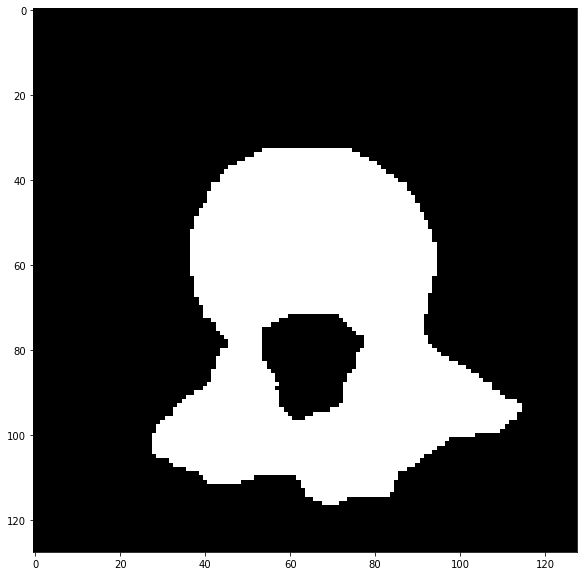

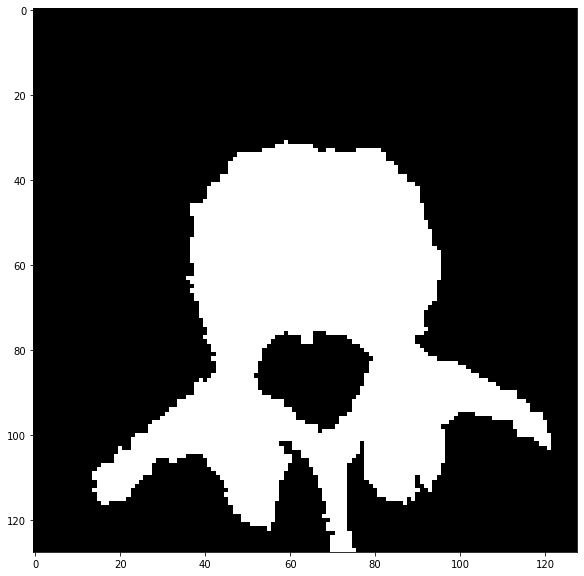

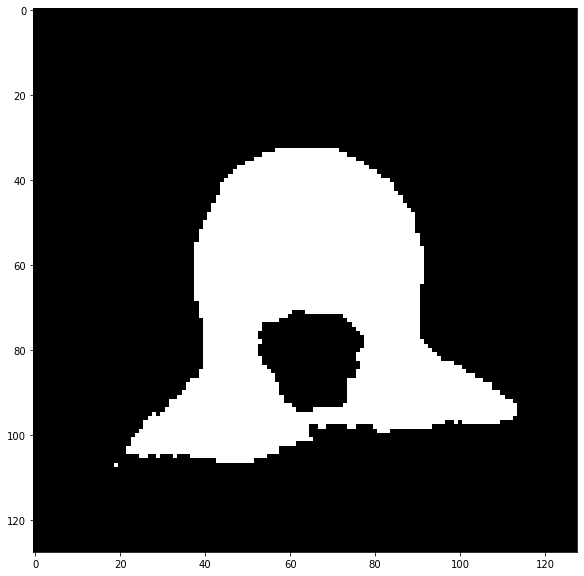

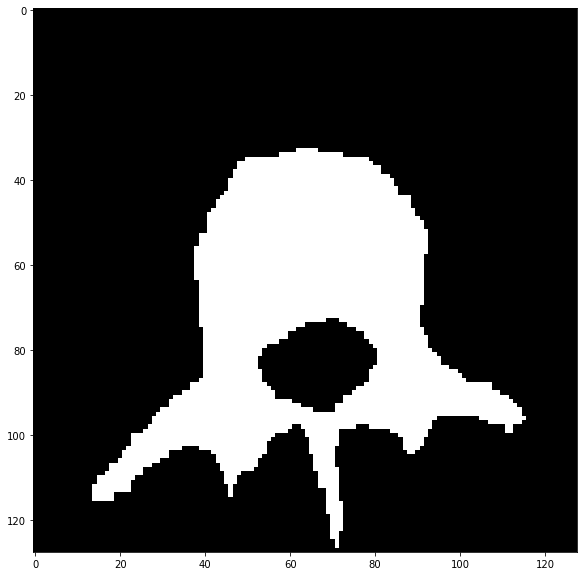

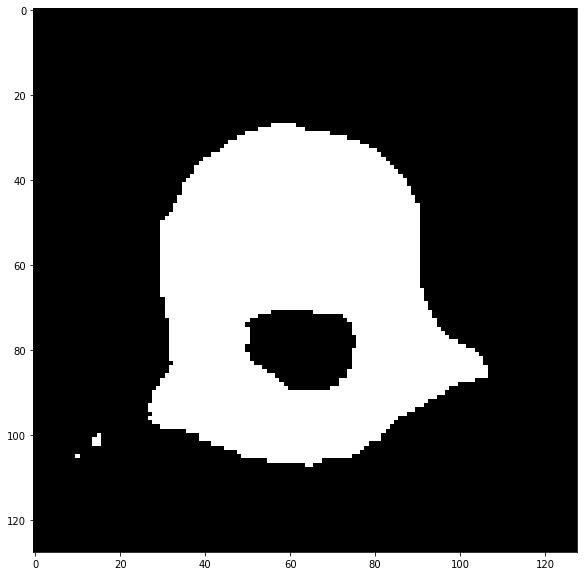

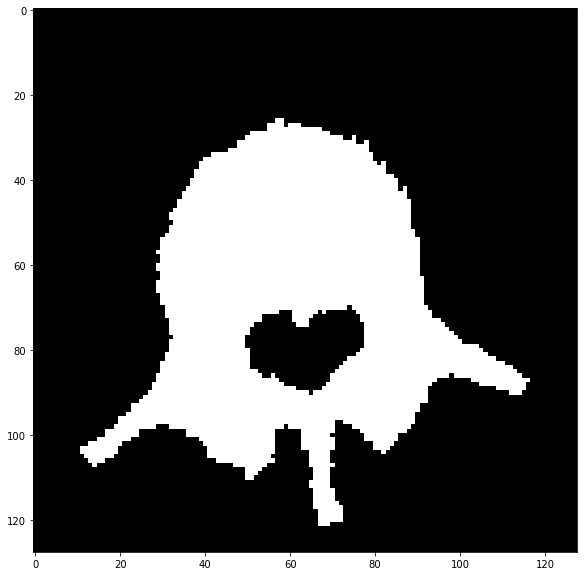

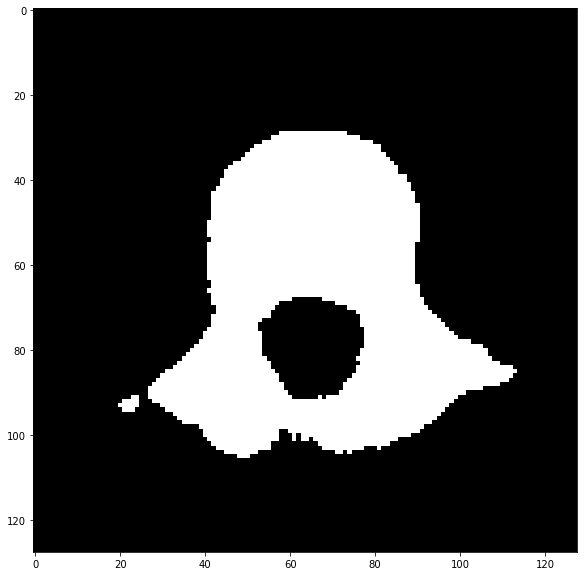

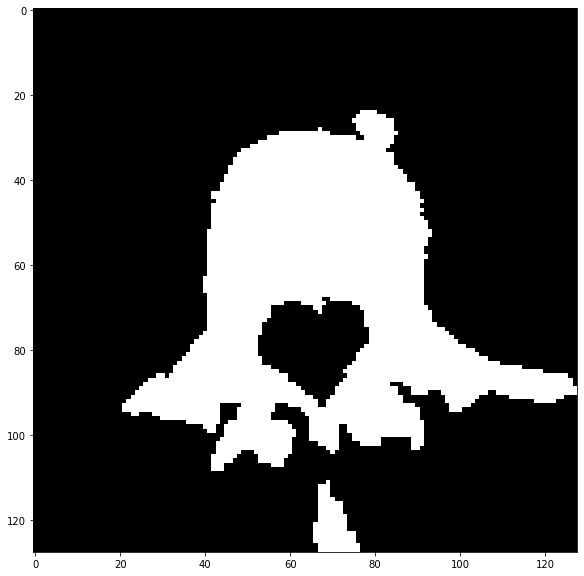

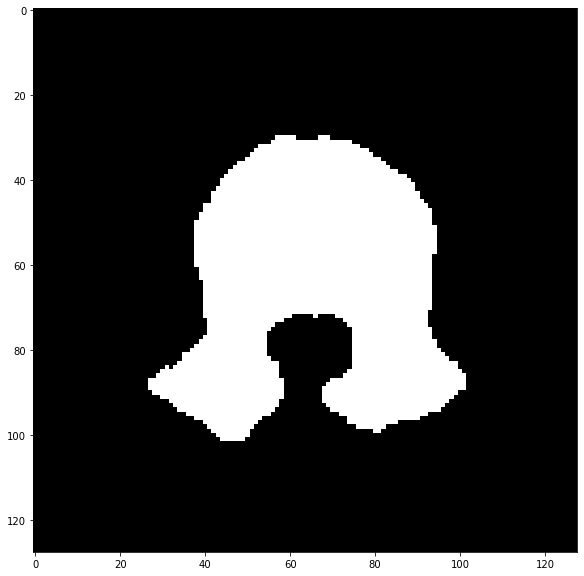

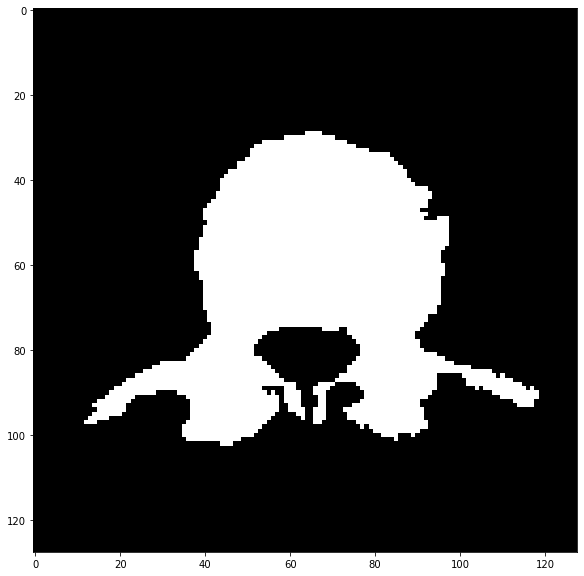

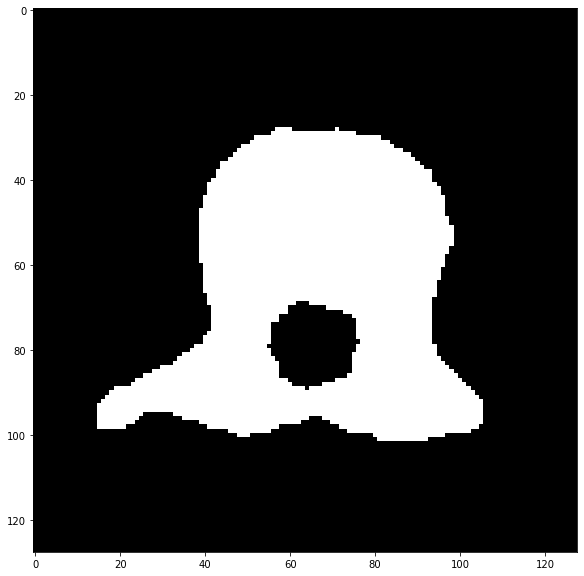

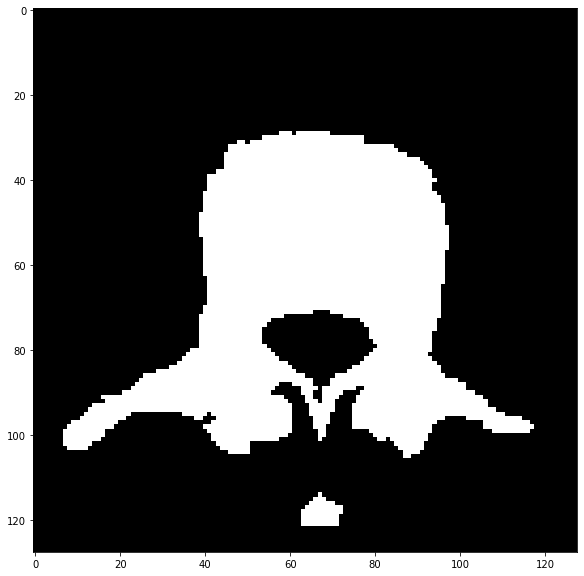

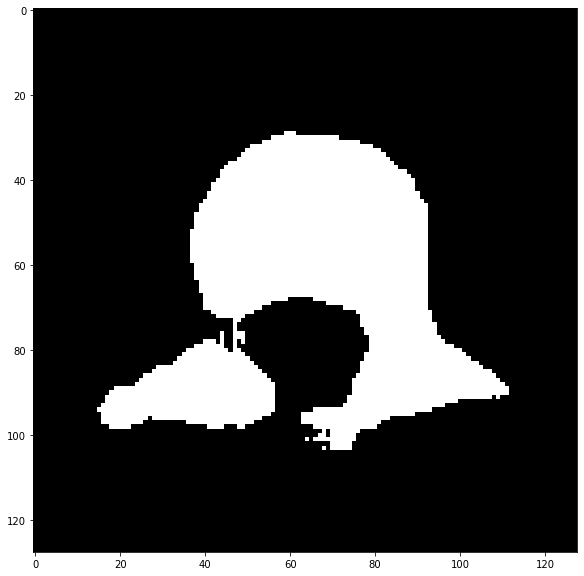

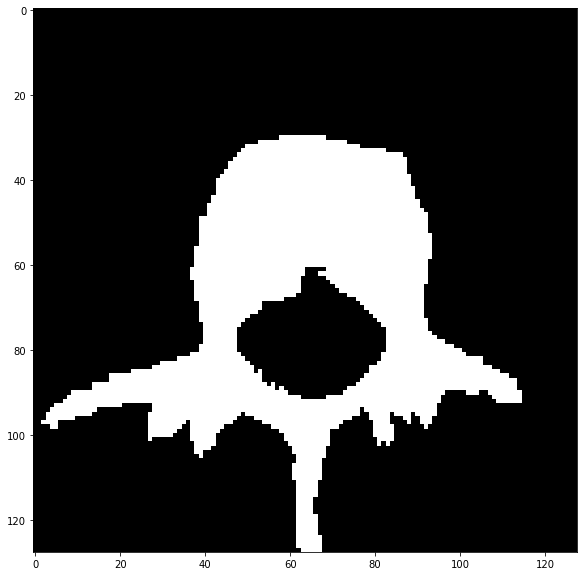

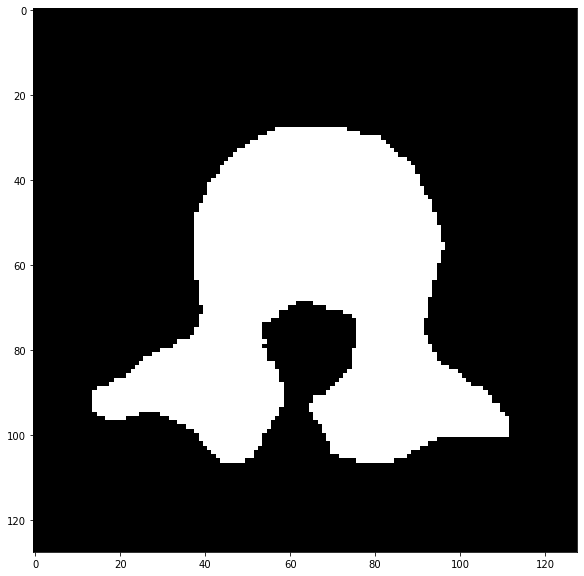

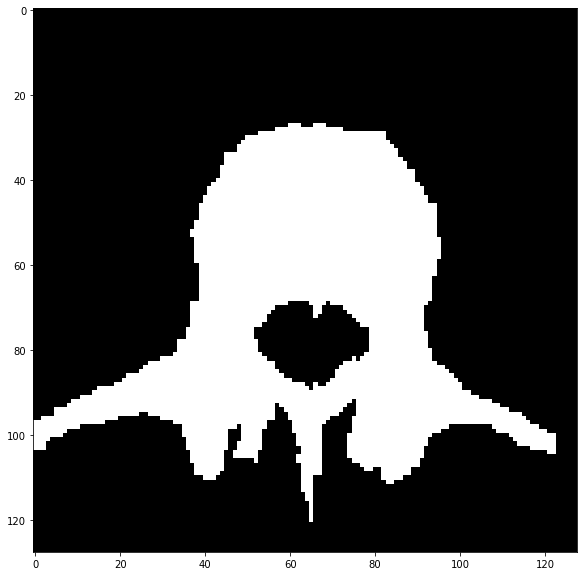

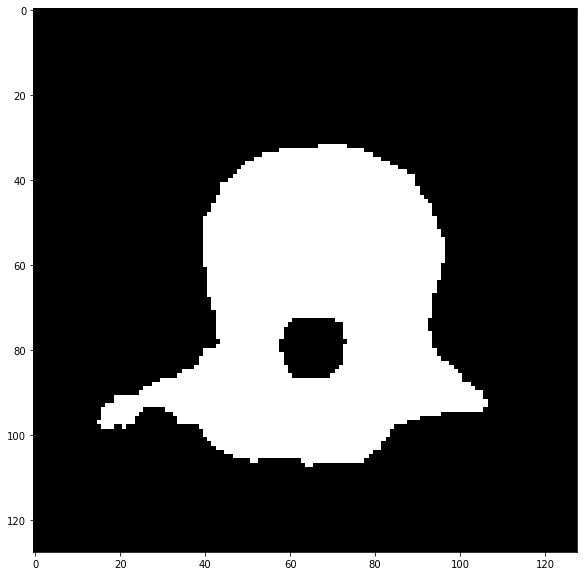

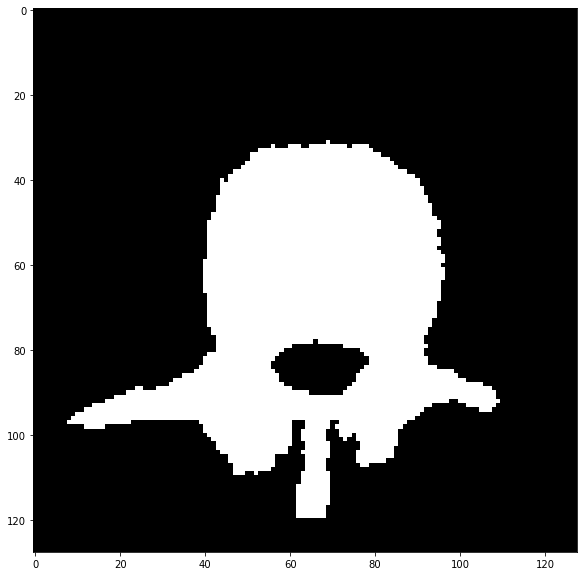

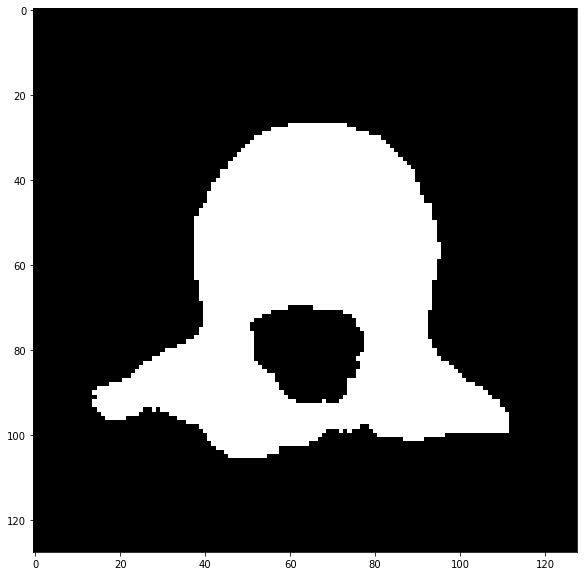

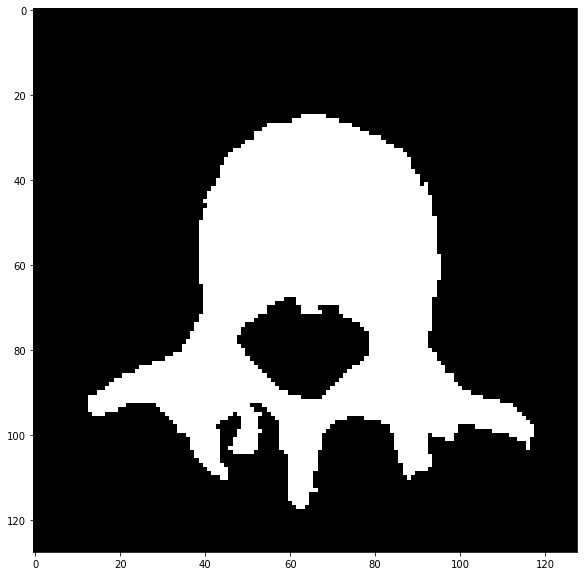

In [11]:
# autoencoder.fit_generator(generator,
#                           validation_data=(inpIm_train, labIm_train),
#                           steps_per_epoch=100,
#                           epochs=100,
#                           callbacks=[checkpoint])
# aaa = e.predict(masks)
# np.save('latentVectors',aaa)



pred = autoencoder.predict(inpIm_test)

filename_test = 'Fold_'+str(cv)+'/test_DAE_'
filename_pred = 'Fold_'+str(cv)+'/pred_DAE_'
fileName = 'model_tests/AutoEnkoder/dice_coeff'+str(cv)+'.txt'
f = open(fileName, 'w')
inpIm_test = inpIm_test[:10]
labIm_test = labIm_test[:10]

for n, (inp, labIm) in enumerate(zip(inpIm_test, labIm_test)):
    predicted = pred[n]>0.5
    inp = inp>0.5
    showImage(predicted)
    showImage(labIm)
    dice = Dice(predicted, labIm)
    dice2 = Dice(inp, labIm)

    cv2.imwrite('pred'+str(n)+'.png',predicted*255)
    cv2.imwrite('org'+str(n)+'.png',labIm*255)

    f.write(str(dice))
    f.write(str(dice2))
    f.write(';\n')


f.close()
plt.show()